In [5]:
import pandas as pd
import numpy as np
from pathlib import Path  
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import os
from spacy.lang.en.stop_words import STOP_WORDS
from tabulate import tabulate
from clsDataProcessing import DataProcessing
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import load_model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Project background
Emotional states including fear, rage, joy, and sadness can all have an impact on our mental well-being and ability to make decisions. This project will analyse the emotions in GoEmotions dataset presented in paper . About 58 thousand Reddit comments with human annotations assigned to 27 emotions or neutral are included in the original dataset. Our team has grouped the 27 emotions into the below 13 labels to better classify the customer review.

# 2. Dataset Analysis

## Download the Goemotions Raw dataset using the bash command
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

In [156]:
#load the datasets from csv files into dataframes 
#used the wget(linux command) to download the data

dataset_dir = "./dataset/full_dataset/"
dfs = []
for filename in os.listdir(dataset_dir):
    if filename.endswith(".csv"):
        dfs.append(pd.read_csv(os.path.join(dataset_dir, filename), encoding="utf-8"))
raw_data = pd.concat(dfs)
print(f"Total Number of Records: {len(raw_data['id'])}")
print(f"Total Distinct Examples based on ID: {len(set(raw_data['id']))}")

Total Number of Records: 211225
Total Distinct Examples based on ID: 58011


In [2]:
# Trying to load the dataset from the hugging face library, which has the cleaned version of data

# From Go emotions paper
# To minimize the noise in our data, we filter out emotion labels selected by only a single annotator. 
#We keep examples with at least one label after this filtering is performed—this amounts to 93% of the original data. 
#We randomly split this data into train (80%), dev (10%) and test (10%) sets. We only evaluate on the test set once the model is finalized.

import datasets
import pandas as pd
from datasets import load_dataset

# Load the dataset
dataset = datasets.load_dataset('go_emotions')

# Convert the dataset to a pandas dataframe
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_validation = pd.DataFrame(dataset['validation'])
df_merge = pd.concat([df_train, df_test, df_validation], axis=0)
# Save the dataframe to a CSV file#
print('Train:', df_train.shape, 'Test:' , df_test.shape, 'Validation:', df_validation.shape, 'Merged:',  df_merge.shape)

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/Asus/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


  0%|          | 0/3 [00:00<?, ?it/s]

Train: (43410, 3) Test: (5427, 3) Validation: (5426, 3) Merged: (54263, 3)


In [4]:
# Load the google amotions taxonomy
with open("./dataset/emotions.txt", "r") as file:
    googleEmotions_taxonomy = file.read().split("\n")
len(googleEmotions_taxonomy)

28

In [5]:
# Load the team emotions taxonomy
with open(r"./dataset/emotions_team.txt", "r") as file:
    team_emotions_taxonomy = file.read().split("\n")
len(team_emotions_taxonomy)

14

# 3: Data Analysis and Visualization

In [6]:
#create team emotion mapping to map the 28 emotion to 14 emotions
with open('./dataset/Team_emotion_mapping.json') as emo_mapping_file:
    team_emotions = json.load(emo_mapping_file)
emotions_mapping = {}
emotions_mapping_keys = []

In [7]:
# Building the list - to hold the final keys of team mapping
# Dictionary - to hold the key value pair of mapping from Go_Emotion 28 emotions to 14 emotions of teams
for key, values in team_emotions.items():
    for emotion in values:
        emotions_mapping[emotion] = key
emotions_mapping_keys = list(team_emotions.keys())
print(emotions_mapping_keys)
print(emotions_mapping)

['joy', 'desire', 'pride', 'agreement', 'surprise', 'love', 'confusion', 'anger', 'disgust', 'sadness', 'fear', 'optimism', 'disappointment', 'neutral']
{'joy': 'joy', 'amusement': 'joy', 'excitement': 'joy', 'desire': 'desire', 'pride': 'pride', 'admiration': 'pride', 'relief': 'pride', 'approval': 'agreement', 'realization': 'agreement', 'surprise': 'surprise', 'curiosity': 'surprise', 'love': 'love', 'caring': 'love', 'confusion': 'confusion', 'anger': 'anger', 'disapproval': 'anger', 'disgust': 'disgust', 'annoyance': 'disgust', 'sadness': 'sadness', 'grief': 'sadness', 'remorse': 'sadness', 'embarrassment': 'sadness', 'fear': 'fear', 'nervousness': 'fear', 'optimism': 'optimism', 'gratitude': 'optimism', 'disappointment': 'disappointment', 'neutral': 'neutral'}


In [8]:
# Building the dictionary to hold the team emotions 
all_dictTeamEmotions = {}
iKey = 0
for i in emotions_mapping_keys:
    all_dictTeamEmotions[iKey] = i
    iKey += 1 

In [9]:
# display the top 2 rows
df_train.head(2)

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i


### 3.1 Data Transformation

In [10]:
# Defining a function that maps each google emotion index to emotion description 
def getDescription(lsInter):
    arr = []  
    
    for i in lsInter:  
        arr.append(googleEmotions_taxonomy[int(i)])
    return arr
# Applying the function
df_merge['description'] = df_merge['labels'].apply(getDescription)


In [11]:
# Defining a function that maps each index to emotion labels
def getTeamDescription(strDescription):
    setDesc = set()  
    result = ''    
    for i in strDescription:  
        setDesc.add(emotions_mapping[i])
    for i, value in enumerate(setDesc):
        if isinstance(value, str):
            result += value
            if i != len(setDesc) - 1:
                result += ', '
    return result 
# Applying the function
df_merge['team_description'] = df_merge['description'].apply(getTeamDescription)

In [12]:
# Label encoding
# Building the label column in dataframe to find the keys 
val_list = list(all_dictTeamEmotions.values())
def getTeamlabels(strTeamDesc):
    strDesc = ''
    inter = strTeamDesc.split(', ')    
    for i in inter:        
        if len(strDesc) > 0:
            strDesc += ', '
        n = val_list.index(i)        
        strDesc += str(n)    
    return strDesc  
# Applying the function
df_merge['team_labels'] = df_merge['team_description'].apply(getTeamlabels)         

In [13]:
# Reordering the columns
df_merge = df_merge[['text', 'id', 'labels','description', 'team_labels', 'team_description']]
# rename the columns 
df_merge.rename(columns={"labels": "GE_labels", 'description': 'GE_description'}, inplace=True)

In [14]:
# Convertings emotion indices into list of indices
df_merge['team_labels'] = df_merge['team_labels'].apply(lambda x: x.split(','))
df_merge['team_description'] = df_merge['team_description'].apply(lambda x: x.split(','))

In [15]:
# OneHot encoding for multi-label classification
for emo in team_emotions_taxonomy:
    df_merge[emo] = np.zeros((len(df_merge),1))
    df_merge[emo] = df_merge['team_description'].apply(lambda x: 1 if emo in x else 0)

In [16]:
# display the rows of transformed data
df_merge.head(1)

,text,id,GE_labels,GE_description,team_labels,team_description,joy,desire,pride,agreement,surprise,love,confusion,anger,disgust,sadness,fear,optimism,disappointment,neutral
0,My favourite food is anything I didn't have to...,eebbqej,[27],[neutral],[13],[neutral],0,0,0,0,0,0,0,0,0,0,0,0,0,1


### 3.2 Data Analysis

In [17]:
# Keeping only necessary columns
df_Goemotions = df_merge
df_Goemotions = df_Goemotions.drop(['team_description','team_labels'], axis=1)

In [18]:
# Computing number of samples per emotion
classes_GE_count = df_Goemotions.loc[:,team_emotions_taxonomy].sum(axis=0).sort_values(ascending=False)

## 3.3 Go emotion Visualization

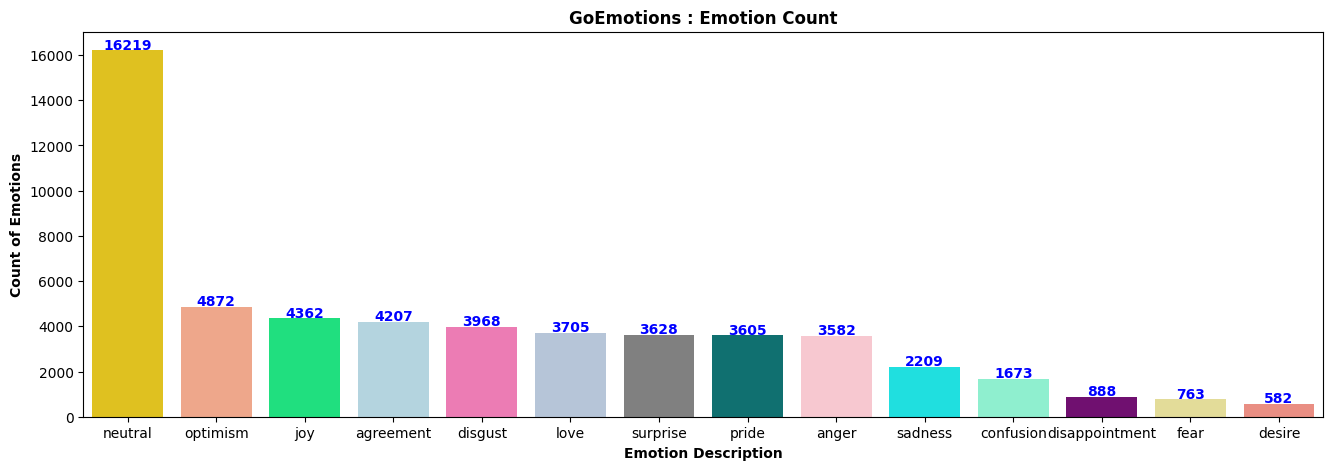

In [19]:
# Visualizing the number of samples per classes
plt.figure(figsize=(16,5))
colors = ['#FFD700', '#FFA07A', '#00FF7F', '#ADD8E6', '#FF69B4', '#B0C4DE', '#808080', '#008080', '#FFC0CB', '#00FFFF', '#7FFFD4', '#800080', '#F0E68C', '#FA8072']
ax = sns.barplot(x=classes_GE_count.index, y=classes_GE_count.values, orient='v', palette=colors)

for i, v in enumerate(classes_GE_count.values):
    ax.text(i, v + 50, str(v), ha='center', fontweight='bold', color='blue')
    
plt.title("GoEmotions : Emotion Count", fontweight='bold')
plt.ylabel("Count of Emotions", fontweight='bold')
plt.xlabel("Emotion Description", fontweight='bold')
plt.show()

In [20]:
# Found the distribution of data across for pareto analysis

dfCount = pd.DataFrame(classes_GE_count)
dfCount.rename(columns={0: 'Count'}, inplace=True)
dfCount = dfCount.reset_index()
dfCount.rename(columns={'index': 'Emotions'}, inplace=True)
dfCount = dfCount[['Emotions', 'Count']]

dfCount = dfCount.sort_values('Count', ascending=False)
dfCount['Cumulative Count'] = dfCount['Count'].cumsum()
dfCount['Cumulative Percentage'] = (dfCount['Cumulative Count'] / dfCount['Count'].sum()) * 100
style_object = dfCount.style \
    .set_caption('Pareto Analysis on Emotion dataset') \
    .set_table_styles([{'selector': 'caption', 'props': [('text-align', 'left')]}]) \
    .hide_index() \
    .background_gradient(cmap='Blues', subset=['Count'])
display(style_object)

C:\Users\Asus\AppData\Local\Temp\ipykernel_7512\1241667007.py:15: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  style_object = dfCount.style \


Emotions,Count,Cumulative Count,Cumulative Percentage
neutral,16219,16219,29.889612
optimism,4872,21091,38.868105
joy,4362,25453,46.906732
agreement,4207,29660,54.659713
disgust,3968,33628,61.972246
love,3705,37333,68.800103
surprise,3628,40961,75.486059
pride,3605,44566,82.129628
anger,3582,48148,88.730811
sadness,2209,50357,92.801725


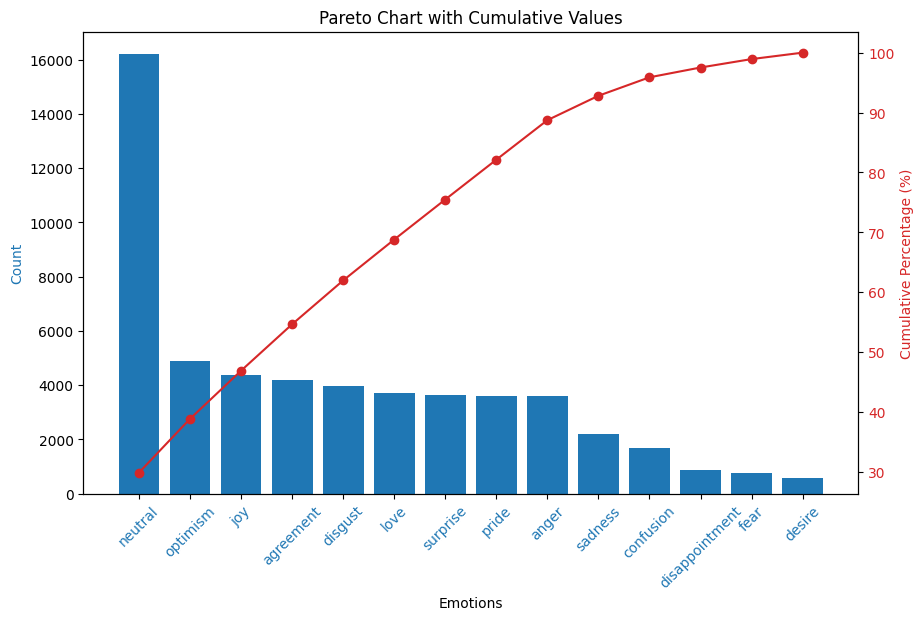

In [21]:

# Create a Pareto chart with cumulative values
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(dfCount['Emotions'], dfCount['Count'], color='tab:blue')
ax1.set_xlabel('Emotions')
ax1.set_ylabel('Count', color='tab:blue')
ax1.tick_params(axis='x', labelcolor='tab:blue',rotation =45)

ax2 = ax1.twinx()
ax2.plot(dfCount['Emotions'], dfCount['Cumulative Percentage'], color='tab:red', marker='o')
ax2.set_ylabel('Cumulative Percentage (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Pareto Chart with Cumulative Values')
plt.show()

# Train Test dataset Manual Split

In [22]:
# Building a function that will divide in train, validation and test sets
data_size = len(df_Goemotions) 
train_size = int(0.8 * data_size)
val_size = int(0.1 * data_size)
test_size = data_size - train_size - val_size

def get_train_val_test(df):
    train = df.iloc[:train_size, :]
    val = df.iloc[train_size:train_size+val_size, :]
    test = df.iloc[train_size+val_size:train_size+val_size+test_size, :]
    return train, val, test

# Dividing back in train, validation and test datasets (GoEmotions)
train_GE, val_GE, test_GE = get_train_val_test(df_Goemotions)

# Print out the sizes of each split
print(f"Train set size: {len(train_GE)}")
print(f"Validation set size: {len(val_GE)}")
print(f"Test set size: {len(test_GE)}")

Train set size: 43410
Validation set size: 5426
Test set size: 5427


In [23]:
# Defining classes representation for each dataset (GoEmotions)
train_count_GE = (train_GE.loc[:, team_emotions_taxonomy].sum(axis=0) / train_size)*100
val_count_GE = (val_GE.loc[:, team_emotions_taxonomy].sum(axis=0) / val_size)*100
test_count_GE = (test_GE.loc[:, team_emotions_taxonomy].sum(axis=0) / test_size)*100

# Constructing a unique dataset for visualization purposes
balance_GE = pd.DataFrame(data=[train_count_GE, val_count_GE, test_count_GE]).T.reset_index(drop=False)
balance_GE.columns = ['Emotion', 'Train', 'Validation', 'Test']
balance_GE = balance_GE.sort_values('Train', ascending=False)
balance_GE = balance_GE.melt(id_vars='Emotion', var_name='Dataset', value_vars=['Train','Validation', 'Test'], value_name='Percentage')

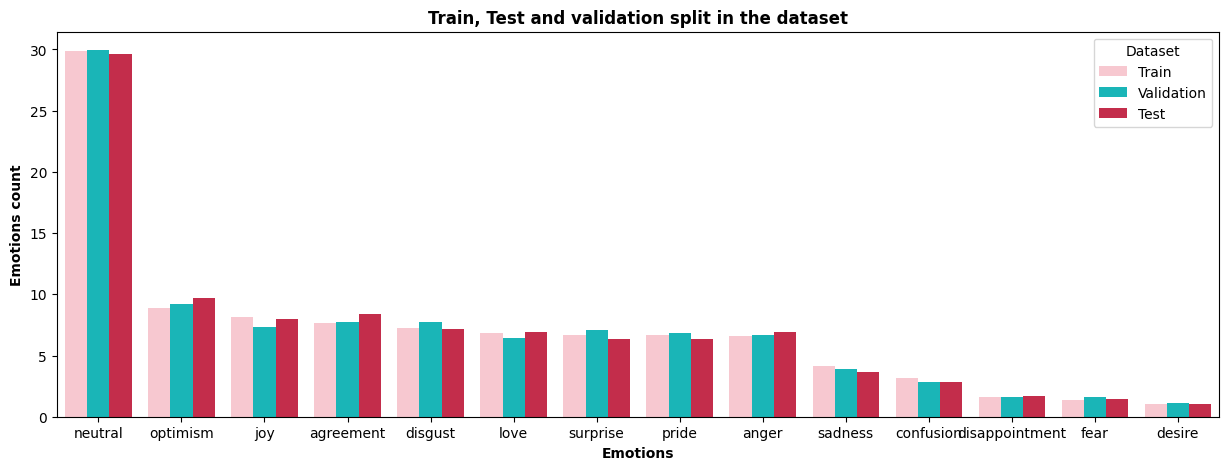

In [24]:
# Classe Balance visualization on GoEmotions
plt.figure(figsize=(15,5))
colors = ['#FFC0CB','#00CED1', '#DC143C']
sns.barplot(x='Emotion', y='Percentage', data=balance_GE, orient='v', hue='Dataset', palette=colors)
plt.title("Train, Test and validation split in the dataset", fontweight='bold')
plt.ylabel("Emotions count", fontweight='bold')
plt.xlabel("Emotions", fontweight='bold')
plt.show()

In [26]:
# Function to display 10 most frequent words in a list of comments
def plot_top_words_barchart(comments):
    comments = comments.str.split() 
    comments = comments.values.tolist() 
    corpus = [word for sample in comments for word in sample if word not in list(STOP_WORDS)+["?","!","name"]] 
    counter = Counter(corpus)  c
    most = counter.most_common(10) 
    
    # Plot the 10 top words and their frequencies
    most = [(word, count) for (word, count) in most]
    x, y = [], []
    for word, count in most[:10]:
        x.append(word)
        y.append(count)   
    return x,y, most 

In [27]:
df = pd.DataFrame (team_emotions_taxonomy, columns = ['Emotions'])
df['Words'] = ''
df['Counts'] = ''
for index, emotions in enumerate(team_emotions_taxonomy): 
    x, y, most = plot_top_words_barchart(df_Goemotions.loc[df_Goemotions[team_emotions_taxonomy[index]]==1,"text"])
    df.at[index, 'Words'] = x
    df.at[index, 'Counts'] = y
# after removing the stopwords
print(tabulate(df, headers='firstrow', showindex='always',tablefmt='fancy_grid'))

╒═════╤════════════════╤══════════════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════╕
│   0 │ joy            │ ['I', '[NAME]', 'lol', 'like', "I'm", 'happy', 'Lol', 'fun', 'This', 'good']             │ [1437, 494, 463, 304, 261, 211, 208, 172, 162, 157]   │
╞═════╪════════════════╪══════════════════════════════════════════════════════════════════════════════════════════╪═══════════════════════════════════════════════════════╡
│   1 │ desire         │ ['I', 'wish', '[NAME]', 'want', 'like', 'need', 'wanted', 'Wish', "I'd", 'hope']         │ [525, 189, 106, 93, 56, 44, 27, 25, 22, 22]           │
├─────┼────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────┤
│   2 │ pride          │ ['I', '[NAME]', 'great', 'good', 'This', 'like', 'pretty', 'The', 'best', 'You']         │ [827, 479, 301, 296, 240

In [28]:
# Function to display 10 most frequent words in a list of comments
def plot_top_words_barchart_woSW(comments):
    comments = comments.str.split() 
    comments = comments.values.tolist() 
    corpus = [word for sample in comments for word in sample] 
    counter = Counter(corpus) 
    most = counter.most_common(10) 
    
    # Plot the 10 top words and their frequencies
    most = [(word, count) for (word, count) in most]
    x, y = [], []
    for word, count in most[:10]:
        x.append(word)
        y.append(count)   
    return x,y, most 

In [29]:
df = pd.DataFrame (team_emotions_taxonomy, columns = ['Emotions'])
df['Words'] = ''
df['Counts'] = ''
for index, emotions in enumerate(team_emotions_taxonomy): 
    x, y, most = plot_top_words_barchart_woSW(df_Goemotions.loc[df_Goemotions[team_emotions_taxonomy[index]]==1,"text"])
    df.at[index, 'Words'] = x
    df.at[index, 'Counts'] = y
# after removing the stopwords
print(tabulate(df, headers='firstrow', showindex='always',tablefmt='fancy_grid'))

╒═════╤════════════════╤═════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│   0 │ joy            │ ['I', 'the', 'a', 'to', 'and', 'is', 'of', 'that', 'you', 'it']         │ [1437, 1408, 1158, 1120, 728, 678, 628, 565, 538, 506]       │
╞═════╪════════════════╪═════════════════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╡
│   1 │ desire         │ ['I', 'to', 'a', 'wish', 'the', 'and', '[NAME]', 'want', 'for', 'that'] │ [525, 268, 199, 189, 187, 126, 106, 93, 86, 82]              │
├─────┼────────────────┼─────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────┤
│   2 │ pride          │ ['the', 'a', 'is', 'I', 'to', 'and', 'of', '[NAME]', 'in', 'that']      │ [1218, 1113, 879, 827, 710, 603, 603, 479, 403, 359]         │
├─────┼────────────────┼────

In [30]:
dpData = DataProcessing()
# Applying the preprocessing function on the dataset
df_Goemotions["Clean_text"] = df_Goemotions["text"].apply(dpData.preprocess_corpus)
df = pd.DataFrame (team_emotions_taxonomy, columns = ['Emotions'])
df['Words'] = ''
df['Counts'] = ''
for index, emotions in enumerate(team_emotions_taxonomy): 
    x, y, most = plot_top_words_barchart(df_Goemotions.loc[df_Goemotions[team_emotions_taxonomy[index]]==1,"Clean_text"])
    df.at[index, 'Words'] = x
    df.at[index, 'Counts'] = y

In [31]:
# after removing the stop words by applying on the cleaned data
print(tabulate(df, headers='firstrow', showindex='always',tablefmt='fancy_grid'))

╒═════╤════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════╕
│   0 │ joy            │ ['lol', 'haha', 'happy', 'like', 'fun', 'funny', 'glad', 'good', 'laughing', 'got']                       │ [1017, 415, 394, 323, 247, 227, 226, 225, 183, 171]   │
╞═════╪════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════╪═══════════════════════════════════════════════════════╡
│   1 │ desire         │ ['wish', 'want', 'like', 'need', 'wanted', 'hope', 'good', 'people', 'day', 'know']                       │ [230, 112, 61, 45, 28, 25, 23, 21, 19, 19]            │
├─────┼────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────┤
│   2 │ pride          │ ['great', 'good', 'like', 'awe

In [32]:
df_Goemotions = df_Goemotions[['Clean_text',  'joy', 'desire', 'pride', 'agreement', 'surprise', 'love', 'confusion', 'anger', 'disgust', 'sadness', 'fear', 'optimism', 'disappointment', 'neutral' ]]
df_Goemotions.to_csv('./dataset/GE_clean.csv')

# Experiments

### Experiment 1 - Pipeline 1 - LSTM 

In [33]:
import en_core_web_sm
nlp = en_core_web_sm.load()
from clsDataProcessing import DataProcessing

In [34]:
dpData = DataProcessing()

In [35]:
# Applying the preprocessing function on the dataset
train_GE["Clean_text"] = train_GE["text"].apply(dpData.preprocess_corpus)
val_GE["Clean_text"] = val_GE["text"].apply(dpData.preprocess_corpus)
test_GE["Clean_text"] = test_GE["text"].apply(dpData.preprocess_corpus)

In [36]:
# select the preferred columns
train_GE = train_GE[['Clean_text',  'joy', 'desire', 'pride', 'agreement', 'surprise', 'love', 'confusion', 'anger', 'disgust', 'sadness', 'fear', 'optimism', 'disappointment', 'neutral' ]]
test_GE = test_GE[['Clean_text',  'joy', 'desire', 'pride', 'agreement', 'surprise', 'love', 'confusion', 'anger', 'disgust', 'sadness', 'fear', 'optimism', 'disappointment', 'neutral' ]]
val_GE = val_GE[['Clean_text',  'joy', 'desire', 'pride', 'agreement', 'surprise', 'love', 'confusion', 'anger', 'disgust', 'sadness', 'fear', 'optimism', 'disappointment', 'neutral' ]]


In [38]:
# save the dataset
train_GE.to_csv('./dataset/train_clean.csv')
test_GE.to_csv('./dataset/test_clean.csv')
val_GE.to_csv('./dataset/val_clean.csv')

In [39]:
rows, columns = train_GE.shape
dataset = 'Train Google Emotions'
print ("{} data size: {}\nRows: {}\nColumns: {}".format(dataset, (rows,columns), rows, columns))
rows, columns = test_GE.shape
print ("{} data size: {}\nRows: {}\nColumns: {}".format('Test Google Emotions', (rows,columns), rows, columns))

Train Google Emotions data size: (43410, 15)
Rows: 43410
Columns: 15
Test Google Emotions data size: (5427, 15)
Rows: 5427
Columns: 15


In [41]:
train_GE_1, test_GE_1, val_GE_1 = train_GE, test_GE, val_GE

In [42]:
# Apply the NLP pipeline like Puctuation removal, tokenization, stopwords removal

train_GE_1["Clean_token"]  = dpData.text_processing_exp1(train_GE_1["Clean_text"])
val_GE_1["Clean_token"]  = dpData.text_processing_exp1(val_GE_1["Clean_text"])
test_GE_1["Clean_token"]  = dpData.text_processing_exp1(test_GE_1["Clean_text"])


In [44]:
# calculate the vocabulary size using count vectorizer
vocab_size_model = dpData.countVocab_exp1(pd.concat([train_GE_1["Clean_token"], val_GE_1["Clean_token"], test_GE_1["Clean_token"]]))

In [45]:
# calculate the tf-idf matrix
tfidf_train_emotions = dpData.createtf_idf_exp1(train_GE_1['Clean_token'], vocab_size_model)
tfidf_val_emotions = dpData.createtf_idf_exp1(val_GE_1['Clean_token'], vocab_size_model)
tfidf_test_emotions = dpData.createtf_idf_exp1(test_GE_1['Clean_token'], vocab_size_model)

# displaying the shape of train and test data
print(tfidf_train_emotions.shape)
print(tfidf_val_emotions.shape)
print(tfidf_test_emotions.shape)

(43410, 17922)
(5426, 6473)
(5427, 6595)


In [46]:
# Defining train and test variables
X_train =  tfidf_train_emotions
y_train = train_GE_1.loc[:,team_emotions_taxonomy].values

X_val =  tfidf_val_emotions
y_val = val_GE_1.loc[:,team_emotions_taxonomy].values

X_test =  tfidf_test_emotions
y_test = test_GE_1.loc[:,team_emotions_taxonomy].values

# Shape validation
print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)
print("The shape of X_val is : ", X_val.shape)
print("The shape of y_val is : ", y_val.shape)
print("The shape of X_test is : ", X_test.shape)
print("The shape of y_test is : ", y_test.shape)

The shape of X_train is :  (43410, 17922)
The shape of y_train is :  (43410, 14)
The shape of X_val is :  (5426, 6473)
The shape of y_val is :  (5426, 14)
The shape of X_test is :  (5427, 6595)
The shape of y_test is :  (5427, 14)


In [47]:
# running the small batch, as its takes time to run in CPU.
# ran in COndow with GPU and got the results tracked
X_train_s = X_train[:100]
y_train_s = y_train[:100]
X_val_s = X_val[:10]
y_val_s = y_val[:10]
X_test_s = X_test[:10]
y_test_s = y_test[:10] 

In [94]:
#LSTM model architetcure
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size_model, 64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=14, activation='softmax')
])

# without GPU  model will take more time to execute, instead download the trained model from the CONDOR server 

#model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#history = model_lstm.fit(X_train_s, y_train_s, validation_data=(X_val_s, y_val_s), epochs=1, batch_size=32)

4/4 [==============================] - 133s 33s/step - loss: 2.6232 - accuracy: 0.2500 - val_loss: 2.6142 - val_accuracy: 0.1000


In [50]:
# ran the model in GPU with the help of Condor server
# Load the saved model
model = load_model(r'./model/lstm_model')

# Access the training history of the model
history = pd.read_csv(r'./model/history.csv')
hist_df = history

In [52]:
hist_df.head(1)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,2.317921,0.307003,2.306873,0.309252


In [53]:
print('LSTM Train loss', np.mean(hist_df['loss']))
print('LSTM Train accuracy', np.mean(hist_df['accuracy']))

LSTM Train loss 2.308677053451538
LSTM Train accuracy 0.30790600180625916


In [54]:
print('LSTM Val loss', np.mean(hist_df['val_loss']))
print('LSTM val accuracy', np.mean(hist_df['val_accuracy']))

LSTM Val loss 2.3068153858184814
LSTM val accuracy 0.3092517554759979


In [55]:
results = model.evaluate(X_test, y_test, batch_size=100)
print('test loss, test acc:', results)

55/55 [==============================] - 219s 4s/step - loss: 2.3091 - accuracy: 0.2967
test loss, test acc: [2.30905818939209, 0.296664834022522]


In [57]:
print('LSTM Test loss', results[0])
print('LSTM Test accuracy', results[1]*100)

LSTM Test loss 2.30905818939209
LSTM Test accuracy 29.666483402252197


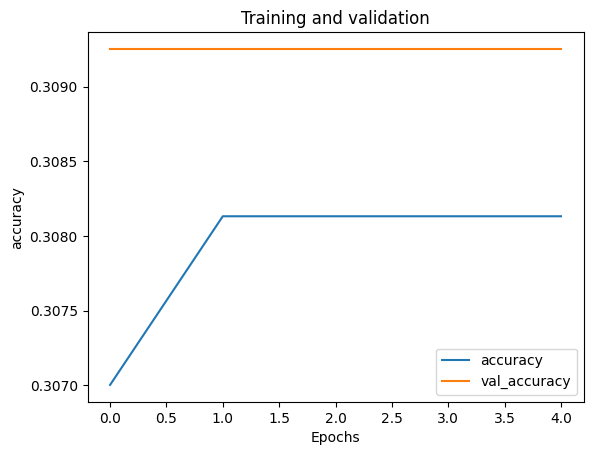

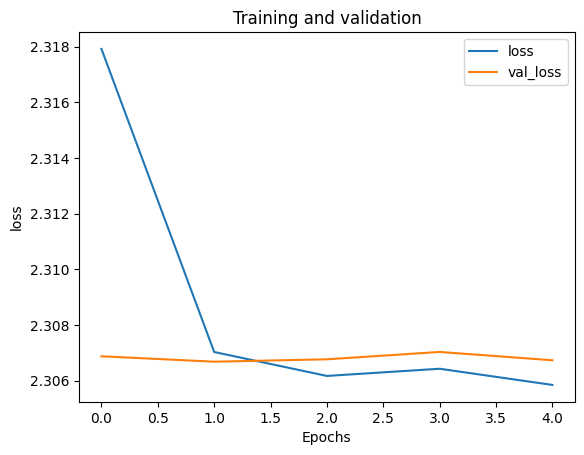

In [58]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history[string])
    plt.plot(history['val_'+string])
    plt.title('Training and validation')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(hist_df, "accuracy")
plot_graphs(hist_df, "loss")

# Pipeline 2 

In [6]:
import pandas as pd
from collections import Counter
from clsDataProcessing import DataProcessing
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import numpy as np


In [9]:
# Process the dataset 
dpData = DataProcessing()
df_Emotions =  dpData.get_data()
google_emotions_taxonomy = dpData.get_taxonomy()

rows, columns = df_Emotions.shape
dataset = 'Google Emotions'
print ("{} data size: {}\nRows: {}\nColumns: {}".format(dataset, (rows,columns), rows, columns))

Google Emotions data size: (42547, 16)
Rows: 42547
Columns: 16


In [10]:
# call the NLP pipeline in the dataproccesing class file to apply the STOP WORDS, Lemmatization and Data cleaning(puctuation removal)
df_Emotions = dpData.nlp_pipeline(df_Emotions)

In [11]:
# building the dictionary of words in the dataset

ge_words = Counter()
for i, sentence in enumerate(df_Emotions["Clean_token"]):
    for word in sentence:  
        ge_words.update([word.lower()])       
#words = {k:v for k,v in train_words.items() if v>1}
words = sorted(ge_words, key=ge_words.get, reverse=True)
words = ['_PAD','_UNK'] + words
# Dictionaries to store the word to index mappings and vice versa
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

In [12]:
#  Create the numerical representation for the dataset

df_Emotions['Clean_TokenNo'] = ''    
for i, sentence in enumerate(df_Emotions["Clean_token"]):
    # Looking up the mapping dictionary and assigning the index to the respective words
    df_Emotions.at[i, 'Clean_TokenNo'] = [word2idx[word] if word in word2idx else 0 for word in sentence]

In [13]:
# Create the train test split 

seq_len = 50  # The length that the sentences will be padded/shortened to
X_train, y_train, X_val, y_val, X_test, y_test = dpData.split_dataset(df_Emotions, google_emotions_taxonomy, 0.1, 0.1, seq_len)

In [14]:
# Shape validation
print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)
print("The shape of X_val is : ", X_val.shape)
print("The shape of y_val is : ", y_val.shape)
print("The shape of X_test is : ", X_test.shape)
print("The shape of y_test is : ", y_test.shape)

The shape of X_train is :  (34462, 50)
The shape of y_train is :  (34462, 14)
The shape of X_val is :  (3830, 50)
The shape of y_val is :  (3830, 14)
The shape of X_test is :  (4255, 50)
The shape of y_test is :  (4255, 14)


In [15]:
# Prepare the Train and test data - X & Y variable for the predictions
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_batch_size = 100
test_batch_size = 100

train_loader = DataLoader(train_data, shuffle=True, batch_size=train_batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=test_batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=test_batch_size, drop_last=True)

In [16]:
# Defining the parameters for the Bi_LSTM model and initialising tht model
vocab_size = len(word2idx) + 1
output_size = 14
embedding_dim = 100
hidden_dim = 10
n_layers = 1
counter = 1
clip = 5

## Experiment 2: RNN

In [146]:
from clsRNN import RNN

In [147]:
lr = 0.05
epochs = 5
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
model = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [148]:
train_acc = []
train_loss_plot = []
for i in range(epochs):  
    model.train()
    train_num_correct = 0  
    train_loss = []

    for inputs, labels in train_loader:
        counter += 1              
        output = model(inputs)
        #loss = nn.BCEWithLogitsLoss()(output[0], labels.float())
        loss = criterion(output, labels.float())        
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()
        pLabels = output.detach().cpu()
        pLabels = pLabels.cpu().numpy()        
        tLabels = labels.cpu().numpy()

        for i, _ in enumerate(pLabels):        
            if ((pLabels[i] >= 0.5) & (tLabels[i] == 1.0)).any():
                train_num_correct += 1  

        
    t_acc = train_num_correct/len(train_loader.dataset)
    #v_acc = val_num_correct/len(val_loader.dataset)
    train_acc.append(t_acc)
    train_loss_plot.append(np.mean(train_loss))
    #validation_acc.append(v_acc)

    print("Epoch: {}/{}...".format(i+1, epochs),
        "Step: {}...".format(counter),
        "Train loss: {:.3f}".format(np.mean(train_loss)),
        "Train accuracy: {:.3f}%".format(t_acc*100))
        #"Val Loss: {:.6f}".format(np.mean(val_loss)),
        #"Validation accuracy: {:.3f}%".format(v_acc*100))

Epoch: 100/5... Step: 70722... Train loss: 2.541 Train accuracy: 72.239%
Epoch: 100/5... Step: 71066... Train loss: 2.537 Train accuracy: 72.982%
Epoch: 100/5... Step: 71410... Train loss: 2.537 Train accuracy: 72.982%
Epoch: 100/5... Step: 71754... Train loss: 2.537 Train accuracy: 72.967%
Epoch: 100/5... Step: 72098... Train loss: 2.537 Train accuracy: 72.973%


In [149]:
model.eval()
val_loss = []
val_num_correct = 0
validation_acc = []

for v_inp, v_lab in val_loader:
    with torch.no_grad():
        v_out = model(v_inp)
        v_loss = criterion(v_out, v_lab.float())
        #val_loss = nn.BCEWithLogitsLoss()(out, lab.float())
        val_loss.append(v_loss.item())

    p_labels = v_out.cpu().numpy()        
    t_labels = v_lab.cpu().numpy()
    for i, _ in enumerate(p_labels):        
        if ((p_labels[i] >= 0.5) & (t_labels[i] == 1.0)).any():
            val_num_correct += 1

v_acc = val_num_correct/len(val_loader.dataset)
validation_acc.append(v_acc)
print("RNN Val Loss: {:.6f}".format(np.mean(val_loss)))
print("RNN Validation accuracy: {:.3f}%".format(v_acc*100))

RNN Val Loss: 2.576605
RNN Validation accuracy: 69.008%


In [153]:
test_losses = []
num_correct = 0
tp = np.zeros(output_size)
fp = np.zeros(output_size)
fn = np.zeros(output_size)
y_pred = []
y_true = []
model.eval()
for inputs, labels in test_loader:
    with torch.no_grad():
        output = model(inputs)
    test_loss = criterion(output, labels.float())
    #test_loss = nn.BCEWithLogitsLoss()(output, labels.float())
    test_losses.append(test_loss.item())
    predicted_labels = output.cpu().numpy()        
    true_labels = labels.cpu().numpy()
    y_pred.append(np.argmax(predicted_labels, axis = 1))
    y_true.append(np.argmax(true_labels, axis=1))
    for i, _ in enumerate(predicted_labels):        
        if ((predicted_labels[i] >= 0.5) & (true_labels[i] == 1.0)).any():
            num_correct += 1

        for j in range(14):
            if ((predicted_labels[i][j] >= 0.5) & (true_labels[i][j] == 1.0)):
                tp[j] += 1
            elif ((predicted_labels[i][j] >= 0.5) & (true_labels[i][j] == 0)):
                fp[j] += 1
            elif ((predicted_labels[i][j] < 0.5) & (true_labels[i][j] == 1.0)):
                fn[j] += 1

print("RNN Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("RNN Test accuracy: {:.3f}%".format(test_acc*100))

RNN Test loss: 2.577
RNN Test accuracy: 68.625%


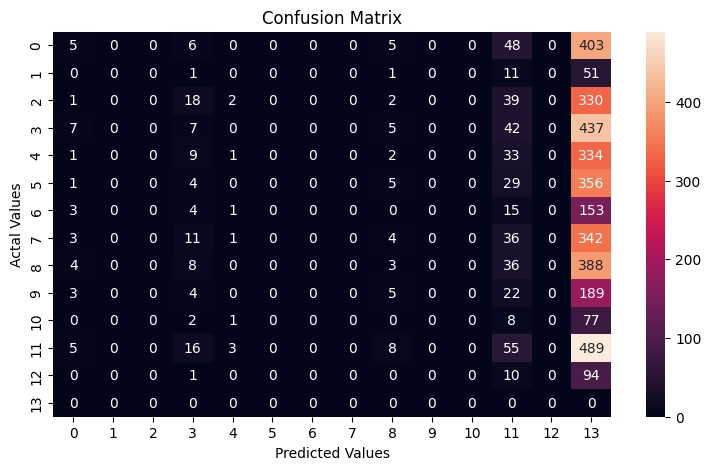

In [154]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
cf_matrix = confusion_matrix(np.concatenate(y_true), np.concatenate(y_pred))
#print(classification_report(np.concatenate(y_true), np.concatenate(y_pred)))
plt.figure(figsize=(9,5))
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [155]:
# print classification report from the sklearn
print(classification_report(np.concatenate(y_true), np.concatenate(y_pred)))

              precision    recall  f1-score   support

           0       0.15      0.01      0.02       467
           1       0.00      0.00      0.00        64
           2       0.00      0.00      0.00       392
           3       0.08      0.01      0.02       498
           4       0.11      0.00      0.01       380
           5       0.00      0.00      0.00       395
           6       0.00      0.00      0.00       176
           7       0.00      0.00      0.00       397
           8       0.07      0.01      0.01       439
           9       0.00      0.00      0.00       223
          10       0.00      0.00      0.00        88
          11       0.14      0.10      0.11       576
          12       0.00      0.00      0.00       105
          13       0.00      0.00      0.00         0

    accuracy                           0.02      4200
   macro avg       0.04      0.01      0.01      4200
weighted avg       0.06      0.02      0.02      4200



c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall 

In [151]:
# Compute the precision and recall for each class
precision = tp / (tp + fp + 1e-10)
recall = tp / (tp + fn + 1e-10)
# Compute the average precision and recall
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
# Print the precision and recall for each class
for i in range(14):
    print(f'Class {i}: precision = {precision[i]:.3f}, recall = {recall[i]:.3f}')
# Print the average precision and recall
print(f'Macro average precision = {avg_precision:.3f}, average recall = {avg_recall:.3f}')
print('F1_Score =', f1)

Class 0: precision = 0.112, recall = 1.000
Class 1: precision = 0.000, recall = 0.000
Class 2: precision = 0.091, recall = 0.924
Class 3: precision = 0.119, recall = 1.000
Class 4: precision = 0.091, recall = 0.982
Class 5: precision = 0.091, recall = 0.241
Class 6: precision = 0.000, recall = 0.000
Class 7: precision = 0.099, recall = 0.299
Class 8: precision = 0.104, recall = 0.986
Class 9: precision = 0.000, recall = 0.000
Class 10: precision = 0.000, recall = 0.000
Class 11: precision = 0.139, recall = 0.998
Class 12: precision = 0.000, recall = 0.000
Class 13: precision = 0.000, recall = 0.000
Macro average precision = 0.060, average recall = 0.459
F1_Score = 0.10674964805062195


## Experiment 3: Bi-lstm model

In [139]:
from clsBiLSTM import BiLSTM

In [140]:
lr = 0.5
epochs = 5

#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
model = BiLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [141]:
train_acc = []
validation_acc = []
train_loss_plot = []
model.train()

for i in range(epochs):  
    train_loss = []
    train_num_correct = 0
    
    for inputs, labels in train_loader:
        counter += 1
        model.zero_grad()
        output = model(inputs)
        #loss = nn.BCEWithLogitsLoss()(output[0], labels.float())
        loss = criterion(output, labels.float())
        
        train_loss.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        pLabels = output.detach().cpu()
        pLabels = pLabels.cpu().numpy()        
        tLabels = labels.cpu().numpy()

        for i, _ in enumerate(pLabels):        
            if ((pLabels[i] >= 0.5) & (tLabels[i] == 1.0)).any():
                train_num_correct += 1
                
    t_acc = train_num_correct/len(train_loader.dataset)
    train_acc.append(t_acc)
    train_loss_plot.append(np.mean(train_loss))
    scheduler.step()
    model.train()
    print("Epoch: {}/{}...".format(i+1, epochs),
        "Step: {}...".format(counter),
        "Train loss: {:.3f}".format(np.mean(train_loss)),
        "Train accuracy: {:.3f}%".format(t_acc*100))

Epoch: 100/5... Step: 69002... Train loss: 2.529 Train accuracy: 83.942%
Epoch: 100/5... Step: 69346... Train loss: 2.526 Train accuracy: 86.083%
Epoch: 100/5... Step: 69690... Train loss: 2.527 Train accuracy: 86.878%
Epoch: 100/5... Step: 70034... Train loss: 2.525 Train accuracy: 86.478%
Epoch: 100/5... Step: 70378... Train loss: 2.526 Train accuracy: 85.976%


In [142]:
# val_h = model.init_hidden(batch_size)
model.eval()
val_loss = []
val_num_correct = 0

for v_inp, v_lab in val_loader:
    with torch.no_grad():
        v_out = model(v_inp)
    v_loss = criterion(v_out, v_lab.float())
    #val_loss = nn.BCEWithLogitsLoss()(out, lab.float())
    val_loss.append(v_loss.item())

    p_labels = v_out.cpu().numpy()        
    t_labels = v_lab.cpu().numpy()
    for i, _ in enumerate(p_labels):        
        if ((p_labels[i] >= 0.5) & (t_labels[i] == 1.0)).any():
            val_num_correct += 1
v_acc = val_num_correct/len(val_loader.dataset)
v_acc = val_num_correct/len(val_loader.dataset)
print("Bi-lstm Val Loss: {:.6f}".format(np.mean(val_loss)))
print("Bi-lstm Validation accuracy: {:.3f}%".format(v_acc*100))

Bi-lstm Val Loss: 2.538848
Bi-lstm Validation accuracy: 84.125%


In [143]:
test_losses = []
num_correct = 0
tp = np.zeros(output_size)
fp = np.zeros(output_size)
fn = np.zeros(output_size)

y_pred = []
y_true = []
model.eval()
for inputs, labels in test_loader:
    with torch.no_grad():
        output = model(inputs)
    test_loss = criterion(output, labels.float())
    #test_loss = nn.BCEWithLogitsLoss()(output, labels.float())
    test_losses.append(test_loss.item())
    predicted_labels = output.cpu().numpy()        
    true_labels = labels.cpu().numpy()
    y_pred.append(np.argmax(predicted_labels, axis = 1))
    y_true.append(np.argmax(true_labels, axis=1))
    for i, _ in enumerate(predicted_labels):        
        if ((predicted_labels[i] >= 0.5) & (true_labels[i] == 1.0)).any():
            num_correct += 1

        for j in range(14):
            if ((predicted_labels[i][j] >= 0.5) & (true_labels[i][j] == 1.0)):
                tp[j] += 1
            elif ((predicted_labels[i][j] >= 0.5) & (true_labels[i][j] == 0)):
                fp[j] += 1
            elif ((predicted_labels[i][j] < 0.5) & (true_labels[i][j] == 1.0)):
                fn[j] += 1

print("Bi-Lstm Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Bi-Lstm Test accuracy: {:.3f}%".format(test_acc*100))

Bi-Lstm Test loss: 2.542
Bi-Lstm Test accuracy: 83.314%


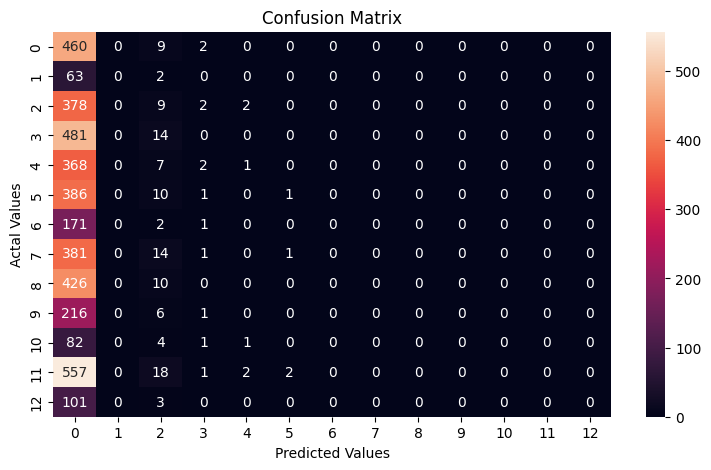

In [144]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
cf_matrix = confusion_matrix(np.concatenate(y_true), np.concatenate(y_pred))
#print(classification_report(np.concatenate(y_true), np.concatenate(y_pred)))
plt.figure(figsize=(9,5))
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [145]:
print(classification_report(np.concatenate(y_true), np.concatenate(y_pred)))

              precision    recall  f1-score   support

           0       0.11      0.98      0.20       471
           1       0.00      0.00      0.00        65
           2       0.08      0.02      0.04       391
           3       0.00      0.00      0.00       495
           4       0.17      0.00      0.01       378
           5       0.25      0.00      0.00       398
           6       0.00      0.00      0.00       174
           7       0.00      0.00      0.00       397
           8       0.00      0.00      0.00       436
           9       0.00      0.00      0.00       223
          10       0.00      0.00      0.00        88
          11       0.00      0.00      0.00       580
          12       0.00      0.00      0.00       104

    accuracy                           0.11      4200
   macro avg       0.05      0.08      0.02      4200
weighted avg       0.06      0.11      0.03      4200



c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
# Compute the precision and recall for each class
precision = tp / (tp + fp + 1e-10)
recall = tp / (tp + fn + 1e-10)
# Compute the average precision and recall
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
# Print the precision and recall for each class
for i in range(14):
    print(f'Class {i}: precision = {precision[i]:.3f}, recall = {recall[i]:.3f}')
# Print the average precision and recall
print(f'Macro average precision = {avg_precision:.3f}, average recall = {avg_recall:.3f}')
print('F1_Score =', f1)

Class 0: precision = 0.111, recall = 1.000
Class 1: precision = 0.000, recall = 0.000
Class 2: precision = 0.093, recall = 1.000
Class 3: precision = 0.119, recall = 1.000
Class 4: precision = 0.091, recall = 1.000
Class 5: precision = 0.095, recall = 1.000
Class 6: precision = 0.000, recall = 0.000
Class 7: precision = 0.096, recall = 0.995
Class 8: precision = 0.102, recall = 1.000
Class 9: precision = 0.103, recall = 0.014
Class 10: precision = 0.000, recall = 0.000
Class 11: precision = 0.139, recall = 1.000
Class 12: precision = 0.000, recall = 0.000
Class 13: precision = 0.000, recall = 0.000
Macro average precision = 0.068, average recall = 0.572
F1_Score = 0.12118958428642546


## Experiment 4:  GRU

In [18]:
from clsGRU import GRU

In [73]:

lr = 0.05
epochs = 20
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
model = GRU(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, word2idx)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [74]:
model.train()
train_loss_plot = []
for i in range(epochs):  
    train_loss = []
    train_num_correct = 0
    
    for inputs, labels in train_loader:
        counter += 1            
        model.zero_grad()
        output = model(inputs)
        #loss = nn.BCEWithLogitsLoss()(output[0], labels.float())
        loss = criterion(output, labels.float())
        
        train_loss.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        pLabels = output.detach().cpu()
        pLabels = pLabels.cpu().numpy()        
        tLabels = labels.cpu().numpy()

        for i, _ in enumerate(pLabels):        
            if ((pLabels[i] >= 0.5) & (tLabels[i] == 1.0)).any():
                train_num_correct += 1
    train_acc = train_num_correct/len(train_loader.dataset)
    train_loss_plot.append(np.mean(train_loss))
    scheduler.step()
    model.train()
    print("Epoch: {}/{}...".format(i+1, epochs),
        "Step: {}...".format(counter),
        "Train loss: {:.3f}".format(np.mean(train_loss)),
        "Train accuracy: {:.3f}%".format(train_acc*100))


Epoch: 100/20... Step: 62122... Train loss: 2.522 Train accuracy: 86.458%
Epoch: 100/20... Step: 62466... Train loss: 2.236 Train accuracy: 83.701%
Epoch: 100/20... Step: 62810... Train loss: 2.268 Train accuracy: 77.523%
Epoch: 100/20... Step: 63154... Train loss: 2.256 Train accuracy: 78.301%
Epoch: 100/20... Step: 63498... Train loss: 2.255 Train accuracy: 77.213%
Epoch: 100/20... Step: 63842... Train loss: 2.248 Train accuracy: 77.497%
Epoch: 100/20... Step: 64186... Train loss: 2.245 Train accuracy: 77.152%
Epoch: 100/20... Step: 64530... Train loss: 2.238 Train accuracy: 76.803%
Epoch: 100/20... Step: 64874... Train loss: 2.242 Train accuracy: 76.200%
Epoch: 100/20... Step: 65218... Train loss: 2.234 Train accuracy: 77.181%
Epoch: 100/20... Step: 65562... Train loss: 2.234 Train accuracy: 77.616%
Epoch: 100/20... Step: 65906... Train loss: 2.228 Train accuracy: 77.337%
Epoch: 100/20... Step: 66250... Train loss: 2.226 Train accuracy: 77.021%
Epoch: 100/20... Step: 66594... Train 

In [109]:
# val_h = model.init_hidden(batch_size)
model.eval()
val_loss = []
val_num_correct = 0

for v_inp, v_lab in val_loader:     
    v_inp, v_lab = v_inp, v_lab
    with torch.no_grad():
        v_out = model(v_inp)
    v_loss = criterion(v_out, v_lab.float())
    #val_loss = nn.BCEWithLogitsLoss()(out, lab.float())
    val_loss.append(v_loss.item())

    p_labels = v_out.cpu().numpy()        
    t_labels = v_lab.cpu().numpy()
    for i, _ in enumerate(p_labels):        
        if ((p_labels[i] >= 0.5) & (t_labels[i] == 1.0)).any():
            val_num_correct += 1
val_acc = val_num_correct/len(val_loader.dataset) 
print("Val Loss: {:.6f}".format(np.mean(val_loss)))
print("Validation accuracy: {:.3f}%".format(val_acc*100))

Val Loss: 2.635088
Validation accuracy: 31.671%


### To print the below chart the training and validation batch should be of equal length - the shown chart has been taken for equal train and validation dataset length

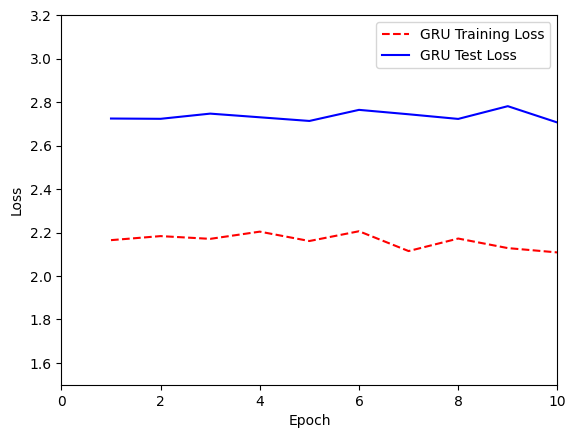

In [55]:


import matplotlib.pyplot as plt
# Get training and test loss histories
# Create count of the number of epochs
epoch_count = range(1, len(train_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['GRU Training Loss', 'GRU Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(1.5, 3.2)
plt.xlim(0, 10)
plt.show()

In [112]:
test_losses = []
num_correct = 0
tp = np.zeros(output_size)
fp = np.zeros(output_size)
fn = np.zeros(output_size)

model.eval()
y_pred = []
y_true = []
for inputs, labels in test_loader:
    with torch.no_grad():
        output = model(inputs)
    test_loss = criterion(output, labels.float())
    #test_loss = nn.BCEWithLogitsLoss()(output, labels.float())
    test_losses.append(test_loss.item())
    predicted_labels = output.cpu().numpy()        
    true_labels = labels.cpu().numpy()

    y_pred.append(np.argmax(predicted_labels, axis = 1))
    y_true.append(np.argmax(true_labels, axis=1))
    #cf_matrix = confusion_matrix(predicted_labels, np.argmax(true_labels, axis=1))
    #sns.heatmap(cf_matrix, annot=True)
    for i, _ in enumerate(predicted_labels):        
        if ((predicted_labels[i] >= 0.5) & (true_labels[i] == 1.0)).any():
            num_correct += 1
            
        for j in range(14):
            if ((predicted_labels[i][j] >= 0.5) & (true_labels[i][j] == 1.0)):
                tp[j] += 1
            elif ((predicted_labels[i][j] >= 0.5) & (true_labels[i][j] == 0)):
                fp[j] += 1
            elif ((predicted_labels[i][j] < 0.5) & (true_labels[i][j] == 1.0)):
                fn[j] += 1

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 2.647
Test accuracy: 29.636%


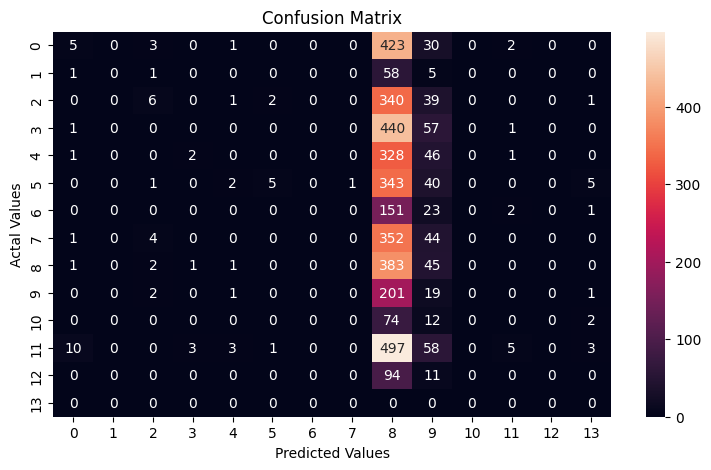

In [135]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
cf_matrix = confusion_matrix(np.concatenate(y_true), np.concatenate(y_pred))
#print(classification_report(np.concatenate(y_true), np.concatenate(y_pred)))
plt.figure(figsize=(9,5))
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()



In [136]:
print(classification_report(np.concatenate(y_true), np.concatenate(y_pred)))

              precision    recall  f1-score   support

           0       0.25      0.01      0.02       464
           1       0.00      0.00      0.00        65
           2       0.32      0.02      0.03       389
           3       0.00      0.00      0.00       499
           4       0.00      0.00      0.00       378
           5       0.62      0.01      0.02       397
           6       0.00      0.00      0.00       177
           7       0.00      0.00      0.00       401
           8       0.10      0.88      0.19       433
           9       0.04      0.08      0.06       224
          10       0.00      0.00      0.00        88
          11       0.45      0.01      0.02       580
          12       0.00      0.00      0.00       105
          13       0.00      0.00      0.00         0

    accuracy                           0.10      4200
   macro avg       0.13      0.07      0.02      4200
weighted avg       0.19      0.10      0.03      4200



c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall 

In [77]:

# Compute the precision and recall for each class
precision = tp / (tp + fp + 1e-10)
recall = tp / (tp + fn + 1e-10)
# Compute the average precision and recall
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
# Print the precision and recall for each class
for i in range(14):
    print(f'Class {i}: precision = {precision[i]:.3f}, recall = {recall[i]:.3f}')
# Print the average precision and recall
print(f'Macro average precision = {avg_precision:.3f}')
print(f'Average recall = {avg_recall:.3f}')
print('F1_Score =', f1)

Class 0: precision = 0.186, recall = 0.017
Class 1: precision = 0.000, recall = 0.000
Class 2: precision = 0.280, recall = 0.018
Class 3: precision = 0.131, recall = 0.343
Class 4: precision = 0.085, recall = 0.383
Class 5: precision = 0.093, recall = 0.737
Class 6: precision = 0.000, recall = 0.000
Class 7: precision = 0.143, recall = 0.010
Class 8: precision = 0.105, recall = 0.993
Class 9: precision = 0.051, recall = 0.814
Class 10: precision = 0.000, recall = 0.000
Class 11: precision = 0.489, recall = 0.040
Class 12: precision = 0.000, recall = 0.000
Class 13: precision = 0.000, recall = 0.000
Macro average precision = 0.112
Average recall = 0.240
F1_Score = 0.15233091165306487


0.05